In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    %pip uninstall -y plotnine
    !git clone https://github.com/bzhanglab/CoPheeMap.git
    %cd CoPheeMap
    %pip install -q -r requirements.txt

In [ ]:
import pandas as pd
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import math
from sklearn import metrics
from statannot import add_stat_annotation
from collections import Counter
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from os import listdir
from os.path import isfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
import pickle
import joblib
import xgboost as xgb

In [2]:
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 

In [3]:
#Kinase name, family, group information
kinases_id=pd.read_excel('KSA/kinase_table.xlsx')
kinases_id.index=kinases_id.Name

#gold standard KSAs
K_S_GPS=pd.read_csv('KSA/KSA_gold_standard.csv',index_col=0)
ks=list(set(K_S_GPS['Gene name']))

#All sites identified in the CPTAC PanCan datasets
a_file = open("PanCan/all_sites_id_1cancer.pkl", "rb")
All_sites = pickle.load(a_file)

In [6]:
#Classify kinases into under-studied and other kinases according to # of known substrates
poor_kinase=[]
other_kinase=[]
poor_num=[]
other_num=[]
for i in ks:
    if 'family' not in i:
        if 'Isoform' not in i:
            tmp=K_S_GPS[K_S_GPS['Gene name']==i]
            if len(set(tmp['seq_15']))<=10:
                poor_kinase.append(i)
                poor_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>10:
                other_kinase.append(i)
                other_num.append(len(set(tmp['seq_15'])))

In [7]:
#Load CoPheeMap
network = pd.read_csv('Supplementary_table/Table_S2_CoPheeMap.tsv.zip', compression='zip', sep='\t')

seq1=[i.split('|')[3] for i in network.site1.tolist()]
seq2=[i.split('|')[3] for i in network.site2.tolist()]
network['seq1']=np.array(seq1)
network['seq2']=np.array(seq2)
sites=list(set(network.site1.tolist()+network.site2.tolist()))
G = nx.Graph()
elist=list(zip(network.site1.tolist(),network.site2.tolist()))
G.add_edges_from(elist)

idx_ST=[]
idx_Y=[]
for i in range(len(network)):
    if network.seq1.iloc[i][7] in ['S','T']:
        idx_ST.append(i)
    if network.seq1.iloc[i][7] in ['Y']:
        idx_Y.append(i)
network_ST=network.iloc[idx_ST,:]
network_Y=network.iloc[idx_Y,:]
lst_ST=list(set(network_ST.site1.tolist()+network_ST.site2.tolist()))
H=G.subgraph(lst_ST)
nodes_ST=max(nx.connected_components(H))
G_ST=G.subgraph(nodes_ST)
network_Y=network.iloc[idx_Y,:]
lst_Y=list(set(network_Y.site1.tolist()+network_Y.site2.tolist()))
H=G.subgraph(lst_Y)
nodes_Y=max(nx.connected_components(H))
G_Y=G.subgraph(nodes_Y)

In [8]:
#Load embeddings of KMap and CoPheeMap
kk_emb=pd.read_csv('CoPheeKSA/kinase_network/n2v_KK_PPI_PCC.csv',index_col=0)
cophee_emb=pd.read_csv('CoPheeMap/data_construction/n2v_networkST.csv', index_col=0)

In [11]:
#Supervised model trained with one static feature: PSSM scores
auc=[]
label=[]
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/static_features/test/test_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train.dropna()
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    idx=random.sample(range(len(data_neg)),10*len(data_train))
    data_neg=data_neg.iloc[idx]
    
    y=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_neg))))
    y_pred=np.concatenate((data_train.PSSM_score,data_neg.PSSM))
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
    auc.append(metrics.auc(fpr, tpr))
    label.append('PSSM')

In [14]:
#Supervised model trained with dynamic features + PSSM scores + CoPheeMap info + KMap info
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train[~data_train['PSSM'].isna()]
    
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    data_neg.index=range(len(data_neg))
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_eval_neg=data_neg.iloc[idx]
    idx_removed=data_eval_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_test_neg=data_neg.iloc[idx]
    idx_removed=data_test_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_eval_neg=data_eval_neg[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_eval_neg])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_eval_neg))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    
    auc.append(auc_tmp)
    label.append('CoPheeKSA')

[0]	train-auc:0.87407	eval-auc:0.85568
[1]	train-auc:0.87682	eval-auc:0.85912
[2]	train-auc:0.89918	eval-auc:0.86608
[3]	train-auc:0.90070	eval-auc:0.86680
[4]	train-auc:0.90049	eval-auc:0.86704
[5]	train-auc:0.90116	eval-auc:0.86632
[6]	train-auc:0.90215	eval-auc:0.86424
[7]	train-auc:0.90706	eval-auc:0.86000
[8]	train-auc:0.90772	eval-auc:0.86120
[9]	train-auc:0.90814	eval-auc:0.86232
[10]	train-auc:0.90895	eval-auc:0.86184
[11]	train-auc:0.90899	eval-auc:0.86088
[12]	train-auc:0.91029	eval-auc:0.86024
[13]	train-auc:0.91137	eval-auc:0.85944


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.86400	eval-auc:0.89880
[1]	train-auc:0.87976	eval-auc:0.91512
[2]	train-auc:0.90379	eval-auc:0.94208
[3]	train-auc:0.90515	eval-auc:0.94512
[4]	train-auc:0.90554	eval-auc:0.94496
[5]	train-auc:0.90582	eval-auc:0.94472
[6]	train-auc:0.90614	eval-auc:0.94568
[7]	train-auc:0.90666	eval-auc:0.94552
[8]	train-auc:0.90704	eval-auc:0.94544
[9]	train-auc:0.90979	eval-auc:0.94584
[10]	train-auc:0.91018	eval-auc:0.94968
[11]	train-auc:0.91250	eval-auc:0.95168
[12]	train-auc:0.91449	eval-auc:0.95096
[13]	train-auc:0.91633	eval-auc:0.95096
[14]	train-auc:0.91775	eval-auc:0.95080
[15]	train-auc:0.91841	eval-auc:0.95128
[16]	train-auc:0.92069	eval-auc:0.95096
[17]	train-auc:0.92268	eval-auc:0.95096
[18]	train-auc:0.92343	eval-auc:0.95048
[19]	train-auc:0.92428	eval-auc:0.95064
[20]	train-auc:0.92627	eval-auc:0.95112
[21]	train-auc:0.92769	eval-auc:0.95352


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[22]	train-auc:0.92868	eval-auc:0.95296
[23]	train-auc:0.92900	eval-auc:0.95248
[24]	train-auc:0.93035	eval-auc:0.95232
[25]	train-auc:0.93102	eval-auc:0.95296
[26]	train-auc:0.93170	eval-auc:0.95472
[27]	train-auc:0.93299	eval-auc:0.95768
[28]	train-auc:0.93382	eval-auc:0.95776
[29]	train-auc:0.93418	eval-auc:0.95872
[30]	train-auc:0.93494	eval-auc:0.95920
[31]	train-auc:0.93559	eval-auc:0.95968
[32]	train-auc:0.93616	eval-auc:0.96000
[33]	train-auc:0.93664	eval-auc:0.96080
[34]	train-auc:0.93683	eval-auc:0.96176
[35]	train-auc:0.93699	eval-auc:0.96128
[36]	train-auc:0.93724	eval-auc:0.96048
[37]	train-auc:0.93761	eval-auc:0.96032
[38]	train-auc:0.93832	eval-auc:0.96000
[39]	train-auc:0.93870	eval-auc:0.96096
[40]	train-auc:0.93917	eval-auc:0.96160
[41]	train-auc:0.93969	eval-auc:0.96160
[42]	train-auc:0.94024	eval-auc:0.96256
[43]	train-auc:0.94043	eval-auc:0.96240
[44]	train-auc:0.94096	eval-auc:0.96336
[45]	train-auc:0.94134	eval-auc:0.96352
[46]	train-auc:0.94147	eval-auc:0.96368


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.87092	eval-auc:0.84816
[1]	train-auc:0.89626	eval-auc:0.86872
[2]	train-auc:0.90033	eval-auc:0.88080
[3]	train-auc:0.90184	eval-auc:0.88280
[4]	train-auc:0.90187	eval-auc:0.88280
[5]	train-auc:0.90288	eval-auc:0.88792
[6]	train-auc:0.90538	eval-auc:0.88712
[7]	train-auc:0.90597	eval-auc:0.88744
[8]	train-auc:0.90665	eval-auc:0.89152
[9]	train-auc:0.90758	eval-auc:0.90288
[10]	train-auc:0.90809	eval-auc:0.90344
[11]	train-auc:0.90834	eval-auc:0.90448
[12]	train-auc:0.90980	eval-auc:0.90408
[13]	train-auc:0.91222	eval-auc:0.90416
[14]	train-auc:0.91544	eval-auc:0.90216
[15]	train-auc:0.91617	eval-auc:0.90776
[16]	train-auc:0.91874	eval-auc:0.91448
[17]	train-auc:0.91980	eval-auc:0.91768
[18]	train-auc:0.92066	eval-auc:0.91680
[19]	train-auc:0.92352	eval-auc:0.92256
[20]	train-auc:0.92411	eval-auc:0.92744
[21]	train-auc:0.92464	eval-auc:0.92856
[22]	train-auc:0.92625	eval-auc:0.93128
[23]	train-auc:0.92714	eval-auc:0.93200
[24]	train-auc:0.92825	eval-auc:0.93360
[25]	train

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[26]	train-auc:0.92993	eval-auc:0.93472
[27]	train-auc:0.93083	eval-auc:0.93760
[28]	train-auc:0.93109	eval-auc:0.93696
[29]	train-auc:0.93132	eval-auc:0.93760
[30]	train-auc:0.93204	eval-auc:0.93872
[31]	train-auc:0.93267	eval-auc:0.93968
[32]	train-auc:0.93379	eval-auc:0.94288
[33]	train-auc:0.93437	eval-auc:0.94400
[34]	train-auc:0.93484	eval-auc:0.94480
[35]	train-auc:0.93575	eval-auc:0.94480
[36]	train-auc:0.93598	eval-auc:0.94432
[37]	train-auc:0.93640	eval-auc:0.94560
[38]	train-auc:0.93651	eval-auc:0.94400
[39]	train-auc:0.93799	eval-auc:0.94944
[40]	train-auc:0.93833	eval-auc:0.94992
[41]	train-auc:0.93905	eval-auc:0.94752
[42]	train-auc:0.93957	eval-auc:0.94928
[43]	train-auc:0.93975	eval-auc:0.94912
[44]	train-auc:0.94041	eval-auc:0.94928
[45]	train-auc:0.94040	eval-auc:0.95280
[46]	train-auc:0.94084	eval-auc:0.95168
[47]	train-auc:0.94133	eval-auc:0.95200
[48]	train-auc:0.94167	eval-auc:0.95280
[49]	train-auc:0.94220	eval-auc:0.95248
[50]	train-auc:0.94235	eval-auc:0.95280


[15]	train-auc:0.91899	eval-auc:0.91656
[16]	train-auc:0.91988	eval-auc:0.91904
[17]	train-auc:0.92114	eval-auc:0.91904
[18]	train-auc:0.92168	eval-auc:0.91856
[19]	train-auc:0.92360	eval-auc:0.91816
[20]	train-auc:0.92542	eval-auc:0.92496
[21]	train-auc:0.92568	eval-auc:0.92592
[22]	train-auc:0.92639	eval-auc:0.92528
[23]	train-auc:0.92693	eval-auc:0.92568
[24]	train-auc:0.92777	eval-auc:0.92624


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.92861	eval-auc:0.92688
[26]	train-auc:0.93000	eval-auc:0.92992
[27]	train-auc:0.93054	eval-auc:0.92832
[28]	train-auc:0.93096	eval-auc:0.93136
[29]	train-auc:0.93118	eval-auc:0.93408
[30]	train-auc:0.93157	eval-auc:0.93424
[31]	train-auc:0.93262	eval-auc:0.93520
[32]	train-auc:0.93287	eval-auc:0.93472
[33]	train-auc:0.93341	eval-auc:0.93200
[34]	train-auc:0.93366	eval-auc:0.93232
[35]	train-auc:0.93419	eval-auc:0.93344
[36]	train-auc:0.93463	eval-auc:0.93472
[37]	train-auc:0.93501	eval-auc:0.93152
[38]	train-auc:0.93568	eval-auc:0.93280
[39]	train-auc:0.93614	eval-auc:0.93360
[40]	train-auc:0.93663	eval-auc:0.93504
[0]	train-auc:0.87596	eval-auc:0.89104
[1]	train-auc:0.87671	eval-auc:0.89088
[2]	train-auc:0.89987	eval-auc:0.88312
[3]	train-auc:0.90039	eval-auc:0.88344
[4]	train-auc:0.90084	eval-auc:0.88328
[5]	train-auc:0.90420	eval-auc:0.92312
[6]	train-auc:0.90783	eval-auc:0.92248
[7]	train-auc:0.90845	eval-auc:0.92336
[8]	train-auc:0.90919	eval-auc:0.92592
[9]	train

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-auc:0.92929	eval-auc:0.94160
[25]	train-auc:0.93012	eval-auc:0.94352
[26]	train-auc:0.93043	eval-auc:0.94352
[27]	train-auc:0.93101	eval-auc:0.94432
[28]	train-auc:0.93218	eval-auc:0.94560
[29]	train-auc:0.93260	eval-auc:0.94432
[30]	train-auc:0.93359	eval-auc:0.94496
[31]	train-auc:0.93411	eval-auc:0.94512
[32]	train-auc:0.93505	eval-auc:0.94656
[33]	train-auc:0.93529	eval-auc:0.94608
[34]	train-auc:0.93628	eval-auc:0.94656
[35]	train-auc:0.93673	eval-auc:0.94832
[36]	train-auc:0.93706	eval-auc:0.94912
[37]	train-auc:0.93768	eval-auc:0.94944
[38]	train-auc:0.93798	eval-auc:0.94928
[39]	train-auc:0.93850	eval-auc:0.94928
[40]	train-auc:0.93924	eval-auc:0.95200
[41]	train-auc:0.93977	eval-auc:0.95280
[42]	train-auc:0.94039	eval-auc:0.95360
[43]	train-auc:0.94056	eval-auc:0.95360
[44]	train-auc:0.94085	eval-auc:0.95440
[45]	train-auc:0.94124	eval-auc:0.95488
[46]	train-auc:0.94135	eval-auc:0.95520
[47]	train-auc:0.94181	eval-auc:0.95488
[48]	train-auc:0.94230	eval-auc:0.95488


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.87720	eval-auc:0.88216
[1]	train-auc:0.88235	eval-auc:0.89560
[2]	train-auc:0.89221	eval-auc:0.89688
[3]	train-auc:0.89886	eval-auc:0.89600
[4]	train-auc:0.89964	eval-auc:0.89912
[5]	train-auc:0.90006	eval-auc:0.89952
[6]	train-auc:0.90210	eval-auc:0.89840
[7]	train-auc:0.90246	eval-auc:0.89968
[8]	train-auc:0.90331	eval-auc:0.89888
[9]	train-auc:0.90443	eval-auc:0.89952
[10]	train-auc:0.90484	eval-auc:0.90016
[11]	train-auc:0.90914	eval-auc:0.89744
[12]	train-auc:0.90958	eval-auc:0.89752
[13]	train-auc:0.91096	eval-auc:0.89880
[14]	train-auc:0.91291	eval-auc:0.89920
[15]	train-auc:0.91451	eval-auc:0.91320
[16]	train-auc:0.91513	eval-auc:0.91296
[17]	train-auc:0.91779	eval-auc:0.92344
[18]	train-auc:0.91855	eval-auc:0.92160
[19]	train-auc:0.92122	eval-auc:0.92432
[20]	train-auc:0.92194	eval-auc:0.92512
[21]	train-auc:0.92378	eval-auc:0.92144
[22]	train-auc:0.92446	eval-auc:0.92376
[23]	train-auc:0.92541	eval-auc:0.92424
[24]	train-auc:0.92551	eval-auc:0.92312


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.92724	eval-auc:0.92456
[26]	train-auc:0.92754	eval-auc:0.92352
[27]	train-auc:0.92804	eval-auc:0.92576
[28]	train-auc:0.92886	eval-auc:0.92912
[29]	train-auc:0.92978	eval-auc:0.93040
[30]	train-auc:0.93030	eval-auc:0.93024
[31]	train-auc:0.93077	eval-auc:0.92864
[32]	train-auc:0.93133	eval-auc:0.92880
[33]	train-auc:0.93249	eval-auc:0.92912
[34]	train-auc:0.93282	eval-auc:0.92848
[35]	train-auc:0.93344	eval-auc:0.92816
[36]	train-auc:0.93383	eval-auc:0.92848
[37]	train-auc:0.93444	eval-auc:0.93248
[38]	train-auc:0.93494	eval-auc:0.93328
[39]	train-auc:0.93549	eval-auc:0.93376
[40]	train-auc:0.93608	eval-auc:0.93392
[41]	train-auc:0.93629	eval-auc:0.93424
[42]	train-auc:0.93718	eval-auc:0.93360
[43]	train-auc:0.93762	eval-auc:0.93472
[44]	train-auc:0.93812	eval-auc:0.93456
[45]	train-auc:0.93856	eval-auc:0.93472
[46]	train-auc:0.93871	eval-auc:0.93488
[47]	train-auc:0.93931	eval-auc:0.93616
[48]	train-auc:0.93959	eval-auc:0.93568
[49]	train-auc:0.94014	eval-auc:0.93824


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.87518	eval-auc:0.93776
[1]	train-auc:0.87838	eval-auc:0.94672
[2]	train-auc:0.89853	eval-auc:0.96144
[3]	train-auc:0.90027	eval-auc:0.96264
[4]	train-auc:0.90230	eval-auc:0.96280
[5]	train-auc:0.90304	eval-auc:0.96344
[6]	train-auc:0.90308	eval-auc:0.96312
[7]	train-auc:0.90444	eval-auc:0.96392
[8]	train-auc:0.90993	eval-auc:0.96368
[9]	train-auc:0.91070	eval-auc:0.96472
[10]	train-auc:0.91140	eval-auc:0.96520
[11]	train-auc:0.91145	eval-auc:0.96520
[12]	train-auc:0.91481	eval-auc:0.96768
[13]	train-auc:0.91582	eval-auc:0.96688
[14]	train-auc:0.91741	eval-auc:0.96816
[15]	train-auc:0.91776	eval-auc:0.96800
[16]	train-auc:0.91832	eval-auc:0.96928
[17]	train-auc:0.91913	eval-auc:0.96896
[18]	train-auc:0.92140	eval-auc:0.97016
[19]	train-auc:0.92160	eval-auc:0.97032
[20]	train-auc:0.92233	eval-auc:0.97064
[21]	train-auc:0.92384	eval-auc:0.97064
[22]	train-auc:0.92440	eval-auc:0.96968
[23]	train-auc:0.92593	eval-auc:0.97048
[24]	train-auc:0.92672	eval-auc:0.97048


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.92710	eval-auc:0.97112
[26]	train-auc:0.92846	eval-auc:0.97208
[27]	train-auc:0.92956	eval-auc:0.97288
[28]	train-auc:0.93014	eval-auc:0.97272
[29]	train-auc:0.93114	eval-auc:0.97448
[30]	train-auc:0.93183	eval-auc:0.97536
[31]	train-auc:0.93244	eval-auc:0.97552
[32]	train-auc:0.93293	eval-auc:0.97600
[33]	train-auc:0.93369	eval-auc:0.97504
[34]	train-auc:0.93468	eval-auc:0.97600
[35]	train-auc:0.93528	eval-auc:0.97632
[36]	train-auc:0.93559	eval-auc:0.97680
[37]	train-auc:0.93628	eval-auc:0.97712
[38]	train-auc:0.93696	eval-auc:0.97616
[39]	train-auc:0.93733	eval-auc:0.97792
[40]	train-auc:0.93792	eval-auc:0.97808
[41]	train-auc:0.93828	eval-auc:0.97888
[42]	train-auc:0.93882	eval-auc:0.97968
[43]	train-auc:0.93923	eval-auc:0.97968
[44]	train-auc:0.93971	eval-auc:0.97984
[45]	train-auc:0.93996	eval-auc:0.98000
[46]	train-auc:0.94043	eval-auc:0.97984
[47]	train-auc:0.94076	eval-auc:0.98016
[48]	train-auc:0.94106	eval-auc:0.98016
[49]	train-auc:0.94120	eval-auc:0.98048


In [15]:
#Supervised model trained with CoPheeMap info + KMap info
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15']
for i in range(10):
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    data_neg=data_neg.replace(0,np.nan)
    data_neg.index=range(len(data_neg))
    #data_neg=data_neg[~data_neg['PSSM'].isna()]
    
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_train=data_train[~data_train['PSSM'].isna()]
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #X_train=X_train.replace(np.nan,0)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('CoPheeMap+KMap')

[0]	train-auc:0.56125	eval-auc:0.50464
[1]	train-auc:0.56783	eval-auc:0.48216
[2]	train-auc:0.60394	eval-auc:0.49512
[3]	train-auc:0.61880	eval-auc:0.53456
[4]	train-auc:0.61995	eval-auc:0.53392
[5]	train-auc:0.62599	eval-auc:0.53144
[6]	train-auc:0.62503	eval-auc:0.52800
[7]	train-auc:0.63474	eval-auc:0.52968
[8]	train-auc:0.63583	eval-auc:0.53816
[9]	train-auc:0.63860	eval-auc:0.54616
[10]	train-auc:0.63602	eval-auc:0.55584
[11]	train-auc:0.65070	eval-auc:0.58376
[12]	train-auc:0.65613	eval-auc:0.61424
[13]	train-auc:0.66211	eval-auc:0.60280
[14]	train-auc:0.66701	eval-auc:0.63776
[15]	train-auc:0.67095	eval-auc:0.65152
[16]	train-auc:0.67235	eval-auc:0.69792
[17]	train-auc:0.67705	eval-auc:0.70176
[18]	train-auc:0.67839	eval-auc:0.70768
[19]	train-auc:0.67686	eval-auc:0.70520
[20]	train-auc:0.68046	eval-auc:0.70688
[21]	train-auc:0.68100	eval-auc:0.71344
[22]	train-auc:0.68417	eval-auc:0.70512
[23]	train-auc:0.68724	eval-auc:0.71312
[24]	train-auc:0.69302	eval-auc:0.71216
[25]	train

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	train-auc:0.72355	eval-auc:0.74704
[46]	train-auc:0.72566	eval-auc:0.74272
[47]	train-auc:0.72877	eval-auc:0.74400
[48]	train-auc:0.73035	eval-auc:0.74096
0.8227706122448981
[0]	train-auc:0.54016	eval-auc:0.52848
[1]	train-auc:0.60837	eval-auc:0.64280
[2]	train-auc:0.62143	eval-auc:0.65272
[3]	train-auc:0.63716	eval-auc:0.66112
[4]	train-auc:0.63609	eval-auc:0.66336
[5]	train-auc:0.63577	eval-auc:0.66096
[6]	train-auc:0.64181	eval-auc:0.65936
[7]	train-auc:0.64009	eval-auc:0.65920
[8]	train-auc:0.63992	eval-auc:0.64944
[9]	train-auc:0.64834	eval-auc:0.66112
[10]	train-auc:0.65056	eval-auc:0.66704
[11]	train-auc:0.65045	eval-auc:0.68592
[12]	train-auc:0.65758	eval-auc:0.70824
[13]	train-auc:0.66025	eval-auc:0.71928
[14]	train-auc:0.66489	eval-auc:0.75272
[15]	train-auc:0.67018	eval-auc:0.76096
[16]	train-auc:0.67652	eval-auc:0.78048
[17]	train-auc:0.67684	eval-auc:0.79072
[18]	train-auc:0.67999	eval-auc:0.80144
[19]	train-auc:0.67940	eval-auc:0.80432
[20]	train-auc:0.67923	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.772575542355372
[0]	train-auc:0.54062	eval-auc:0.51792
[1]	train-auc:0.56267	eval-auc:0.54504
[2]	train-auc:0.60862	eval-auc:0.55448
[3]	train-auc:0.62090	eval-auc:0.60816
[4]	train-auc:0.63407	eval-auc:0.57832
[5]	train-auc:0.63340	eval-auc:0.60112
[6]	train-auc:0.63664	eval-auc:0.60032
[7]	train-auc:0.64241	eval-auc:0.64288
[8]	train-auc:0.63948	eval-auc:0.61360
[9]	train-auc:0.65179	eval-auc:0.63456
[10]	train-auc:0.66101	eval-auc:0.68736
[11]	train-auc:0.65816	eval-auc:0.69624
[12]	train-auc:0.66547	eval-auc:0.73040
[13]	train-auc:0.66656	eval-auc:0.71528
[14]	train-auc:0.66914	eval-auc:0.72216
[15]	train-auc:0.67020	eval-auc:0.72488
[16]	train-auc:0.68009	eval-auc:0.71424
[17]	train-auc:0.68455	eval-auc:0.70152
[18]	train-auc:0.68391	eval-auc:0.69920
[19]	train-auc:0.68680	eval-auc:0.70528
[20]	train-auc:0.68840	eval-auc:0.71504
[21]	train-auc:0.68805	eval-auc:0.71760
[22]	train-auc:0.69286	eval-auc:0.71888


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.7416638686242789
[0]	train-auc:0.54136	eval-auc:0.49600
[1]	train-auc:0.54381	eval-auc:0.49600
[2]	train-auc:0.56853	eval-auc:0.52160
[3]	train-auc:0.62049	eval-auc:0.51888
[4]	train-auc:0.63317	eval-auc:0.56544
[5]	train-auc:0.63294	eval-auc:0.55896
[6]	train-auc:0.63001	eval-auc:0.56952
[7]	train-auc:0.63491	eval-auc:0.55848
[8]	train-auc:0.62870	eval-auc:0.56056
[9]	train-auc:0.63459	eval-auc:0.59896
[10]	train-auc:0.65184	eval-auc:0.62568
[11]	train-auc:0.66224	eval-auc:0.62760
[12]	train-auc:0.66822	eval-auc:0.63600
[13]	train-auc:0.66774	eval-auc:0.64000
[14]	train-auc:0.67066	eval-auc:0.64832
[15]	train-auc:0.67186	eval-auc:0.65240
[16]	train-auc:0.67257	eval-auc:0.66504
[17]	train-auc:0.67257	eval-auc:0.67336
[18]	train-auc:0.67661	eval-auc:0.66760
[19]	train-auc:0.67614	eval-auc:0.68072
[20]	train-auc:0.67739	eval-auc:0.69392
[21]	train-auc:0.68077	eval-auc:0.69056
[22]	train-auc:0.68349	eval-auc:0.71224
[23]	train-auc:0.68317	eval-auc:0.71952
[24]	train-auc:0.68670	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[46]	train-auc:0.73032	eval-auc:0.80560
[47]	train-auc:0.73109	eval-auc:0.80384
[48]	train-auc:0.73280	eval-auc:0.80288
[49]	train-auc:0.73330	eval-auc:0.80160
[50]	train-auc:0.73457	eval-auc:0.80464
[51]	train-auc:0.73611	eval-auc:0.80768
[52]	train-auc:0.73763	eval-auc:0.80752
[53]	train-auc:0.73966	eval-auc:0.81232
[54]	train-auc:0.73899	eval-auc:0.80464
[55]	train-auc:0.73933	eval-auc:0.80288
[56]	train-auc:0.73978	eval-auc:0.80224
[57]	train-auc:0.74123	eval-auc:0.80352
[58]	train-auc:0.74211	eval-auc:0.80640
[59]	train-auc:0.74279	eval-auc:0.80800
[60]	train-auc:0.74252	eval-auc:0.80784
[61]	train-auc:0.74397	eval-auc:0.81312
[62]	train-auc:0.74390	eval-auc:0.81296
[63]	train-auc:0.74583	eval-auc:0.81136
[64]	train-auc:0.74643	eval-auc:0.81392
[65]	train-auc:0.74771	eval-auc:0.81504
[66]	train-auc:0.74834	eval-auc:0.81168
[67]	train-auc:0.74976	eval-auc:0.81472
[68]	train-auc:0.75272	eval-auc:0.81632
[69]	train-auc:0.75549	eval-auc:0.80512
[70]	train-auc:0.75740	eval-auc:0.80816


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.7760570987654322
[0]	train-auc:0.56225	eval-auc:0.52528
[1]	train-auc:0.56424	eval-auc:0.52464
[2]	train-auc:0.60568	eval-auc:0.56112
[3]	train-auc:0.60785	eval-auc:0.56376
[4]	train-auc:0.60741	eval-auc:0.50352
[5]	train-auc:0.60174	eval-auc:0.55840
[6]	train-auc:0.61294	eval-auc:0.59424
[7]	train-auc:0.62002	eval-auc:0.63192
[8]	train-auc:0.62960	eval-auc:0.64472
[9]	train-auc:0.63620	eval-auc:0.65216
[10]	train-auc:0.64328	eval-auc:0.64024
[11]	train-auc:0.65844	eval-auc:0.64424
[12]	train-auc:0.66178	eval-auc:0.65600
[13]	train-auc:0.66325	eval-auc:0.68984
[14]	train-auc:0.66366	eval-auc:0.69920
[15]	train-auc:0.66902	eval-auc:0.71064
[16]	train-auc:0.66911	eval-auc:0.71552
[17]	train-auc:0.67046	eval-auc:0.72496
[18]	train-auc:0.66984	eval-auc:0.73176
[19]	train-auc:0.67650	eval-auc:0.75112
[20]	train-auc:0.68079	eval-auc:0.76568
[21]	train-auc:0.68840	eval-auc:0.78024
[22]	train-auc:0.69060	eval-auc:0.77456
[23]	train-auc:0.69054	eval-auc:0.75808
[24]	train-auc:0.68955	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.7884604209710744
[0]	train-auc:0.53939	eval-auc:0.59448
[1]	train-auc:0.54181	eval-auc:0.59472
[2]	train-auc:0.60541	eval-auc:0.67656
[3]	train-auc:0.62514	eval-auc:0.71416
[4]	train-auc:0.62494	eval-auc:0.71336
[5]	train-auc:0.63721	eval-auc:0.70888
[6]	train-auc:0.63647	eval-auc:0.70816
[7]	train-auc:0.63550	eval-auc:0.70816
[8]	train-auc:0.63603	eval-auc:0.69776
[9]	train-auc:0.64617	eval-auc:0.72016
[10]	train-auc:0.65727	eval-auc:0.74920
[11]	train-auc:0.66522	eval-auc:0.75032
[12]	train-auc:0.66293	eval-auc:0.76208
[13]	train-auc:0.66898	eval-auc:0.76720
[14]	train-auc:0.67144	eval-auc:0.76624
[15]	train-auc:0.67162	eval-auc:0.77136
[16]	train-auc:0.67469	eval-auc:0.76920
[17]	train-auc:0.67569	eval-auc:0.75672
[18]	train-auc:0.67437	eval-auc:0.76376
[19]	train-auc:0.68050	eval-auc:0.76080
[20]	train-auc:0.68056	eval-auc:0.75256
[21]	train-auc:0.68482	eval-auc:0.76360
[22]	train-auc:0.68485	eval-auc:0.76360
[23]	train-auc:0.68627	eval-auc:0.77160
[24]	train-auc:0.68925	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.7796918351169242
[0]	train-auc:0.54076	eval-auc:0.54600
[1]	train-auc:0.56235	eval-auc:0.61712
[2]	train-auc:0.57499	eval-auc:0.65232
[3]	train-auc:0.61870	eval-auc:0.70448
[4]	train-auc:0.63002	eval-auc:0.72200
[5]	train-auc:0.63021	eval-auc:0.70456
[6]	train-auc:0.63563	eval-auc:0.73320
[7]	train-auc:0.63106	eval-auc:0.73544
[8]	train-auc:0.63233	eval-auc:0.71976
[9]	train-auc:0.64186	eval-auc:0.73448
[10]	train-auc:0.64867	eval-auc:0.75760
[11]	train-auc:0.64886	eval-auc:0.75584
[12]	train-auc:0.65753	eval-auc:0.78424
[13]	train-auc:0.65709	eval-auc:0.77496
[14]	train-auc:0.65982	eval-auc:0.77616
[15]	train-auc:0.66246	eval-auc:0.77360
[16]	train-auc:0.66121	eval-auc:0.79088
[17]	train-auc:0.66899	eval-auc:0.79312
[18]	train-auc:0.67067	eval-auc:0.80960
[19]	train-auc:0.67917	eval-auc:0.81408
[20]	train-auc:0.68027	eval-auc:0.80736
[21]	train-auc:0.68098	eval-auc:0.81456
[22]	train-auc:0.68436	eval-auc:0.81408
[23]	train-auc:0.69010	eval-auc:0.81504
[24]	train-auc:0.69067	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[49]	train-auc:0.73580	eval-auc:0.87456
[50]	train-auc:0.73689	eval-auc:0.87536
[51]	train-auc:0.73752	eval-auc:0.88000
[52]	train-auc:0.74053	eval-auc:0.87936
[53]	train-auc:0.74212	eval-auc:0.87520
[54]	train-auc:0.74217	eval-auc:0.87696
[55]	train-auc:0.74299	eval-auc:0.87888
[56]	train-auc:0.74389	eval-auc:0.88048
[57]	train-auc:0.74632	eval-auc:0.87872
[58]	train-auc:0.74692	eval-auc:0.87952
[59]	train-auc:0.74807	eval-auc:0.88272
[60]	train-auc:0.74847	eval-auc:0.88272
[61]	train-auc:0.74995	eval-auc:0.88320
[62]	train-auc:0.74961	eval-auc:0.88592
[63]	train-auc:0.75081	eval-auc:0.88896
[64]	train-auc:0.75095	eval-auc:0.88144
[65]	train-auc:0.75114	eval-auc:0.88080
[66]	train-auc:0.75124	eval-auc:0.87760
[67]	train-auc:0.75137	eval-auc:0.87680
[68]	train-auc:0.75244	eval-auc:0.87616
[69]	train-auc:0.75300	eval-auc:0.87792
[70]	train-auc:0.75406	eval-auc:0.86960
[71]	train-auc:0.75374	eval-auc:0.87072
[72]	train-auc:0.75428	eval-auc:0.87040
[73]	train-auc:0.75425	eval-auc:0.87264


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.790280864197531
[0]	train-auc:0.54100	eval-auc:0.53384
[1]	train-auc:0.56252	eval-auc:0.57424
[2]	train-auc:0.56471	eval-auc:0.57456
[3]	train-auc:0.61123	eval-auc:0.65576
[4]	train-auc:0.62408	eval-auc:0.67448
[5]	train-auc:0.63555	eval-auc:0.68712
[6]	train-auc:0.63736	eval-auc:0.70184
[7]	train-auc:0.64128	eval-auc:0.69832
[8]	train-auc:0.63938	eval-auc:0.71544
[9]	train-auc:0.64542	eval-auc:0.76272
[10]	train-auc:0.64483	eval-auc:0.78480
[11]	train-auc:0.65437	eval-auc:0.83816
[12]	train-auc:0.65659	eval-auc:0.85424
[13]	train-auc:0.65842	eval-auc:0.86896
[14]	train-auc:0.65754	eval-auc:0.86744
[15]	train-auc:0.66622	eval-auc:0.86368
[16]	train-auc:0.66861	eval-auc:0.88056
[17]	train-auc:0.67411	eval-auc:0.86288
[18]	train-auc:0.67519	eval-auc:0.87040
[19]	train-auc:0.68466	eval-auc:0.87152
[20]	train-auc:0.68681	eval-auc:0.85536
[21]	train-auc:0.68860	eval-auc:0.86272
[22]	train-auc:0.69067	eval-auc:0.85712
[23]	train-auc:0.69090	eval-auc:0.86384
[24]	train-auc:0.68974	eval-auc:

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [16]:
#Supervised model trained with PSSM scores + CoPheeMap info + KMap info
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','PSSM']
for i in range(10):
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    data_neg=data_neg.replace(0,np.nan)
    data_neg=data_neg[~data_neg['PSSM'].isna()]
    data_neg.index=range(len(data_neg))
    
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train[~data_train['PSSM'].isna()]
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    data_train_neg=data_train_neg[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #X_train=X_train.replace(np.nan,0)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('PSSM+CoPheeMap+KMap')

[0]	train-auc:0.87492	eval-auc:0.86424
[1]	train-auc:0.87692	eval-auc:0.86592
[2]	train-auc:0.89887	eval-auc:0.87640
[3]	train-auc:0.90033	eval-auc:0.87720
[4]	train-auc:0.90041	eval-auc:0.87696
[5]	train-auc:0.90146	eval-auc:0.87576
[6]	train-auc:0.90167	eval-auc:0.87472
[7]	train-auc:0.90661	eval-auc:0.89000
[8]	train-auc:0.90658	eval-auc:0.88944
[9]	train-auc:0.90685	eval-auc:0.88896
[10]	train-auc:0.90746	eval-auc:0.89120
[11]	train-auc:0.91081	eval-auc:0.88720
[12]	train-auc:0.91216	eval-auc:0.89816
[13]	train-auc:0.91248	eval-auc:0.89840
[14]	train-auc:0.91463	eval-auc:0.89816
[15]	train-auc:0.91579	eval-auc:0.91336
[16]	train-auc:0.91653	eval-auc:0.91224
[17]	train-auc:0.91672	eval-auc:0.91120
[18]	train-auc:0.91713	eval-auc:0.90768
[19]	train-auc:0.91777	eval-auc:0.91080
[20]	train-auc:0.91824	eval-auc:0.90504
[21]	train-auc:0.91920	eval-auc:0.90560
[22]	train-auc:0.92029	eval-auc:0.90608
[23]	train-auc:0.92084	eval-auc:0.90592
[24]	train-auc:0.92170	eval-auc:0.90512
[25]	train

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.9350285714285714
[0]	train-auc:0.87745	eval-auc:0.91120
[1]	train-auc:0.88018	eval-auc:0.91552
[2]	train-auc:0.90536	eval-auc:0.92664
[3]	train-auc:0.90619	eval-auc:0.92832
[4]	train-auc:0.90622	eval-auc:0.92816
[5]	train-auc:0.90659	eval-auc:0.92832
[6]	train-auc:0.90667	eval-auc:0.92896
[7]	train-auc:0.90675	eval-auc:0.92848
[8]	train-auc:0.90711	eval-auc:0.92832
[9]	train-auc:0.90970	eval-auc:0.92704
[10]	train-auc:0.90988	eval-auc:0.92672
[11]	train-auc:0.91362	eval-auc:0.92128
[12]	train-auc:0.91638	eval-auc:0.91784
[13]	train-auc:0.91692	eval-auc:0.91800
[14]	train-auc:0.91786	eval-auc:0.93400
[15]	train-auc:0.91808	eval-auc:0.92920
[16]	train-auc:0.91916	eval-auc:0.92864
[17]	train-auc:0.91977	eval-auc:0.93504
[18]	train-auc:0.92080	eval-auc:0.93440
[19]	train-auc:0.92093	eval-auc:0.93040
[20]	train-auc:0.92200	eval-auc:0.92888
[21]	train-auc:0.92246	eval-auc:0.93400
[22]	train-auc:0.92301	eval-auc:0.93584
[23]	train-auc:0.92356	eval-auc:0.93496
[24]	train-auc:0.92414	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[44]	train-auc:0.93414	eval-auc:0.94224
[45]	train-auc:0.93481	eval-auc:0.94208
[46]	train-auc:0.93508	eval-auc:0.94176
[47]	train-auc:0.93543	eval-auc:0.94288
[48]	train-auc:0.93564	eval-auc:0.94368
[49]	train-auc:0.93650	eval-auc:0.94576
[50]	train-auc:0.93658	eval-auc:0.94672
[51]	train-auc:0.93698	eval-auc:0.94688
[52]	train-auc:0.93730	eval-auc:0.94800
[53]	train-auc:0.93735	eval-auc:0.94800
[54]	train-auc:0.93776	eval-auc:0.94784
[55]	train-auc:0.93824	eval-auc:0.94816
[56]	train-auc:0.93826	eval-auc:0.94832
[57]	train-auc:0.93849	eval-auc:0.94880
[58]	train-auc:0.93888	eval-auc:0.94832
[59]	train-auc:0.93915	eval-auc:0.94848
[60]	train-auc:0.93952	eval-auc:0.94832
[61]	train-auc:0.93960	eval-auc:0.94816
[62]	train-auc:0.93979	eval-auc:0.94800
[63]	train-auc:0.94025	eval-auc:0.94784
[64]	train-auc:0.94033	eval-auc:0.94832
[65]	train-auc:0.94048	eval-auc:0.94960
[66]	train-auc:0.94082	eval-auc:0.95040
[67]	train-auc:0.94112	eval-auc:0.95056
[68]	train-auc:0.94127	eval-auc:0.95120


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.9052180946857544
[0]	train-auc:0.87102	eval-auc:0.88168
[1]	train-auc:0.87818	eval-auc:0.91208
[2]	train-auc:0.90088	eval-auc:0.90432
[3]	train-auc:0.90173	eval-auc:0.90264
[4]	train-auc:0.90185	eval-auc:0.90264
[5]	train-auc:0.90275	eval-auc:0.90440
[6]	train-auc:0.90285	eval-auc:0.90416
[7]	train-auc:0.90353	eval-auc:0.90528
[8]	train-auc:0.90567	eval-auc:0.90432
[9]	train-auc:0.90685	eval-auc:0.90520
[10]	train-auc:0.90682	eval-auc:0.90504
[11]	train-auc:0.91237	eval-auc:0.91928
[12]	train-auc:0.91295	eval-auc:0.91912
[13]	train-auc:0.91368	eval-auc:0.91664
[14]	train-auc:0.91368	eval-auc:0.91600
[15]	train-auc:0.91452	eval-auc:0.91568
[16]	train-auc:0.91593	eval-auc:0.92352
[17]	train-auc:0.91704	eval-auc:0.92232
[18]	train-auc:0.91703	eval-auc:0.92168
[19]	train-auc:0.91756	eval-auc:0.91960
[20]	train-auc:0.91873	eval-auc:0.91904
[21]	train-auc:0.91957	eval-auc:0.92184
[22]	train-auc:0.92041	eval-auc:0.92080
[23]	train-auc:0.92120	eval-auc:0.92152
[24]	train-auc:0.92158	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.9239738775510203
[0]	train-auc:0.86148	eval-auc:0.87616
[1]	train-auc:0.89111	eval-auc:0.91352
[2]	train-auc:0.90014	eval-auc:0.91040
[3]	train-auc:0.90168	eval-auc:0.90848
[4]	train-auc:0.90184	eval-auc:0.91008
[5]	train-auc:0.90201	eval-auc:0.90968
[6]	train-auc:0.90385	eval-auc:0.91056
[7]	train-auc:0.90376	eval-auc:0.91080
[8]	train-auc:0.90401	eval-auc:0.91096
[9]	train-auc:0.91051	eval-auc:0.92416
[10]	train-auc:0.91074	eval-auc:0.92904
[11]	train-auc:0.91073	eval-auc:0.92904
[12]	train-auc:0.91089	eval-auc:0.92904
[13]	train-auc:0.91201	eval-auc:0.92792
[14]	train-auc:0.91366	eval-auc:0.92696
[15]	train-auc:0.91448	eval-auc:0.92936
[16]	train-auc:0.91499	eval-auc:0.92904
[17]	train-auc:0.91607	eval-auc:0.93368
[18]	train-auc:0.91655	eval-auc:0.93496
[19]	train-auc:0.91784	eval-auc:0.93496
[20]	train-auc:0.91839	eval-auc:0.93464
[21]	train-auc:0.91869	eval-auc:0.93512
[22]	train-auc:0.91975	eval-auc:0.93560
[23]	train-auc:0.92092	eval-auc:0.93512
[24]	train-auc:0.92151	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[47]	train-auc:0.93250	eval-auc:0.95072
[48]	train-auc:0.93331	eval-auc:0.95040
[49]	train-auc:0.93387	eval-auc:0.95168
[50]	train-auc:0.93399	eval-auc:0.95168
[51]	train-auc:0.93480	eval-auc:0.95280
[52]	train-auc:0.93504	eval-auc:0.95264
[53]	train-auc:0.93519	eval-auc:0.95440
[54]	train-auc:0.93570	eval-auc:0.95376
[55]	train-auc:0.93599	eval-auc:0.95408
[56]	train-auc:0.93604	eval-auc:0.95344
[57]	train-auc:0.93620	eval-auc:0.95376
[58]	train-auc:0.93657	eval-auc:0.95360
[59]	train-auc:0.93688	eval-auc:0.95376
[60]	train-auc:0.93701	eval-auc:0.95344
[61]	train-auc:0.93720	eval-auc:0.95392
[62]	train-auc:0.93743	eval-auc:0.95360
[63]	train-auc:0.93766	eval-auc:0.95344
0.9314320987654321
[0]	train-auc:0.87503	eval-auc:0.88568
[1]	train-auc:0.87849	eval-auc:0.88544
[2]	train-auc:0.90012	eval-auc:0.89992
[3]	train-auc:0.90102	eval-auc:0.90048
[4]	train-auc:0.90111	eval-auc:0.90064
[5]	train-auc:0.90464	eval-auc:0.89952
[6]	train-auc:0.90528	eval-auc:0.90304
[7]	train-auc:0.90798	eval-a

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.9225739282024793
[0]	train-auc:0.87365	eval-auc:0.86072
[1]	train-auc:0.87778	eval-auc:0.86184
[2]	train-auc:0.89202	eval-auc:0.86896
[3]	train-auc:0.89956	eval-auc:0.86936
[4]	train-auc:0.90064	eval-auc:0.86856
[5]	train-auc:0.90055	eval-auc:0.86856
[6]	train-auc:0.90129	eval-auc:0.86968
[7]	train-auc:0.90362	eval-auc:0.87032
[8]	train-auc:0.90446	eval-auc:0.86824
[9]	train-auc:0.90692	eval-auc:0.86672
[10]	train-auc:0.90730	eval-auc:0.86720
[11]	train-auc:0.90728	eval-auc:0.86704
[12]	train-auc:0.90725	eval-auc:0.86704
[13]	train-auc:0.90778	eval-auc:0.86960
[14]	train-auc:0.90890	eval-auc:0.86944
[15]	train-auc:0.91095	eval-auc:0.88440
[16]	train-auc:0.91104	eval-auc:0.88368
[17]	train-auc:0.91427	eval-auc:0.87736
[18]	train-auc:0.91470	eval-auc:0.87720
[19]	train-auc:0.91669	eval-auc:0.87256
[20]	train-auc:0.91857	eval-auc:0.87760
[21]	train-auc:0.91974	eval-auc:0.87288
[22]	train-auc:0.91996	eval-auc:0.87456
[23]	train-auc:0.92058	eval-auc:0.87360
[24]	train-auc:0.92104	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.9240305852820718
[0]	train-auc:0.87858	eval-auc:0.86112
[1]	train-auc:0.88232	eval-auc:0.87384
[2]	train-auc:0.89218	eval-auc:0.87240
[3]	train-auc:0.90191	eval-auc:0.91184
[4]	train-auc:0.90203	eval-auc:0.91232
[5]	train-auc:0.90232	eval-auc:0.91312
[6]	train-auc:0.90253	eval-auc:0.91296
[7]	train-auc:0.90265	eval-auc:0.91232
[8]	train-auc:0.90457	eval-auc:0.91184
[9]	train-auc:0.90518	eval-auc:0.91368
[10]	train-auc:0.90528	eval-auc:0.91352
[11]	train-auc:0.90555	eval-auc:0.91464
[12]	train-auc:0.90546	eval-auc:0.91432
[13]	train-auc:0.90581	eval-auc:0.91432
[14]	train-auc:0.90736	eval-auc:0.91560
[15]	train-auc:0.91035	eval-auc:0.91688
[16]	train-auc:0.91233	eval-auc:0.91800
[17]	train-auc:0.91466	eval-auc:0.91568
[18]	train-auc:0.91493	eval-auc:0.91728
[19]	train-auc:0.91607	eval-auc:0.91632
[20]	train-auc:0.91758	eval-auc:0.91480
[21]	train-auc:0.91861	eval-auc:0.91352
[22]	train-auc:0.91971	eval-auc:0.91704
[23]	train-auc:0.92052	eval-auc:0.91536
[24]	train-auc:0.92151	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[47]	train-auc:0.93235	eval-auc:0.92480
[48]	train-auc:0.93270	eval-auc:0.92576
[49]	train-auc:0.93285	eval-auc:0.92560
[50]	train-auc:0.93299	eval-auc:0.92592
[51]	train-auc:0.93388	eval-auc:0.92944
[52]	train-auc:0.93399	eval-auc:0.92944
[53]	train-auc:0.93404	eval-auc:0.92944
[54]	train-auc:0.93409	eval-auc:0.92896
[55]	train-auc:0.93428	eval-auc:0.92944
[56]	train-auc:0.93468	eval-auc:0.93024
[57]	train-auc:0.93507	eval-auc:0.92976
[58]	train-auc:0.93563	eval-auc:0.93136
[59]	train-auc:0.93582	eval-auc:0.93152
[60]	train-auc:0.93612	eval-auc:0.93264
[61]	train-auc:0.93659	eval-auc:0.93344
[62]	train-auc:0.93686	eval-auc:0.93392
[63]	train-auc:0.93706	eval-auc:0.93344
[64]	train-auc:0.93730	eval-auc:0.93328
[65]	train-auc:0.93767	eval-auc:0.93328
[66]	train-auc:0.93779	eval-auc:0.93232
[67]	train-auc:0.93781	eval-auc:0.93200
[68]	train-auc:0.93799	eval-auc:0.93184
[69]	train-auc:0.93823	eval-auc:0.93296
[70]	train-auc:0.93845	eval-auc:0.93408
[71]	train-auc:0.93868	eval-auc:0.93376


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[47]	train-auc:0.93460	eval-auc:0.85376
[48]	train-auc:0.93503	eval-auc:0.85520
[49]	train-auc:0.93567	eval-auc:0.85632
[50]	train-auc:0.93578	eval-auc:0.85648
[51]	train-auc:0.93663	eval-auc:0.85888
[52]	train-auc:0.93693	eval-auc:0.85808
[53]	train-auc:0.93709	eval-auc:0.85504
[54]	train-auc:0.93750	eval-auc:0.85728
[55]	train-auc:0.93787	eval-auc:0.85664
[56]	train-auc:0.93780	eval-auc:0.85664
[57]	train-auc:0.93812	eval-auc:0.85968
[58]	train-auc:0.93824	eval-auc:0.85984
[59]	train-auc:0.93856	eval-auc:0.85936
[60]	train-auc:0.93865	eval-auc:0.85760
[61]	train-auc:0.93909	eval-auc:0.85952
[62]	train-auc:0.93951	eval-auc:0.85936
[63]	train-auc:0.93990	eval-auc:0.86144
[64]	train-auc:0.94016	eval-auc:0.86208
[65]	train-auc:0.94035	eval-auc:0.86176
[66]	train-auc:0.94082	eval-auc:0.86480
[67]	train-auc:0.94114	eval-auc:0.86512
[68]	train-auc:0.94122	eval-auc:0.86592
[69]	train-auc:0.94147	eval-auc:0.86656
[70]	train-auc:0.94160	eval-auc:0.86672
[71]	train-auc:0.94170	eval-auc:0.86672


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[40]	train-auc:0.92915	eval-auc:0.95536
[41]	train-auc:0.92950	eval-auc:0.95792
[42]	train-auc:0.92984	eval-auc:0.95808
[43]	train-auc:0.93016	eval-auc:0.95888
[44]	train-auc:0.93057	eval-auc:0.95840
[45]	train-auc:0.93073	eval-auc:0.95936
[46]	train-auc:0.93132	eval-auc:0.95888
[47]	train-auc:0.93166	eval-auc:0.96160
[48]	train-auc:0.93192	eval-auc:0.96240
[49]	train-auc:0.93215	eval-auc:0.96240
[50]	train-auc:0.93251	eval-auc:0.96256
[51]	train-auc:0.93297	eval-auc:0.96288
[52]	train-auc:0.93318	eval-auc:0.96272
[53]	train-auc:0.93325	eval-auc:0.96272
[54]	train-auc:0.93338	eval-auc:0.96288
[55]	train-auc:0.93392	eval-auc:0.96256
[56]	train-auc:0.93412	eval-auc:0.96288
[57]	train-auc:0.93470	eval-auc:0.96256
[58]	train-auc:0.93486	eval-auc:0.96240
[59]	train-auc:0.93532	eval-auc:0.96416
[60]	train-auc:0.93595	eval-auc:0.96592
[61]	train-auc:0.93622	eval-auc:0.96608
[62]	train-auc:0.93648	eval-auc:0.96528
[63]	train-auc:0.93687	eval-auc:0.96576
[64]	train-auc:0.93726	eval-auc:0.96624


In [17]:
#Supervised model trained with dynamic features
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s']
for i in range(10):
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    data_neg=data_neg.replace(0,np.nan)
    data_neg=data_neg[~data_neg['PSSM'].isna()]
    data_neg.index=range(len(data_neg))
    
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #Avoid overfitting caused by missing values
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('Dynamic_features')

[0]	train-auc:0.55576	eval-auc:0.50256
[1]	train-auc:0.62559	eval-auc:0.64608
[2]	train-auc:0.64873	eval-auc:0.69360
[3]	train-auc:0.65144	eval-auc:0.71480
[4]	train-auc:0.65787	eval-auc:0.71056
[5]	train-auc:0.66160	eval-auc:0.70696
[6]	train-auc:0.66777	eval-auc:0.71616
[7]	train-auc:0.67744	eval-auc:0.75048
[8]	train-auc:0.68434	eval-auc:0.74912
[9]	train-auc:0.69349	eval-auc:0.75848
[10]	train-auc:0.69879	eval-auc:0.76104
[11]	train-auc:0.69949	eval-auc:0.75408
[12]	train-auc:0.70558	eval-auc:0.75112
[13]	train-auc:0.71357	eval-auc:0.77224
[14]	train-auc:0.71639	eval-auc:0.77752
[15]	train-auc:0.72325	eval-auc:0.77120
[16]	train-auc:0.72806	eval-auc:0.77200
[17]	train-auc:0.73147	eval-auc:0.78040
[18]	train-auc:0.73303	eval-auc:0.78976
[19]	train-auc:0.73542	eval-auc:0.79392
[20]	train-auc:0.73732	eval-auc:0.78776
[21]	train-auc:0.74090	eval-auc:0.78648
[22]	train-auc:0.74132	eval-auc:0.79560
[23]	train-auc:0.74265	eval-auc:0.80536
[24]	train-auc:0.74580	eval-auc:0.81416
[25]	train

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-auc:0.75753	eval-auc:0.82720
[31]	train-auc:0.75787	eval-auc:0.82912
[32]	train-auc:0.76040	eval-auc:0.83312
[33]	train-auc:0.76092	eval-auc:0.83008
[34]	train-auc:0.76206	eval-auc:0.83184
[35]	train-auc:0.76281	eval-auc:0.82832
[36]	train-auc:0.76363	eval-auc:0.82560
[37]	train-auc:0.76380	eval-auc:0.82912
[38]	train-auc:0.76465	eval-auc:0.83232
[39]	train-auc:0.76621	eval-auc:0.82480
[40]	train-auc:0.76740	eval-auc:0.82928
[41]	train-auc:0.76908	eval-auc:0.83056
0.8348522448979591
[0]	train-auc:0.60219	eval-auc:0.70160
[1]	train-auc:0.60896	eval-auc:0.69344
[2]	train-auc:0.64544	eval-auc:0.80152
[3]	train-auc:0.65402	eval-auc:0.80824
[4]	train-auc:0.65616	eval-auc:0.79800
[5]	train-auc:0.66426	eval-auc:0.78744
[6]	train-auc:0.67685	eval-auc:0.82640
[7]	train-auc:0.68717	eval-auc:0.82704
[8]	train-auc:0.69288	eval-auc:0.85536
[9]	train-auc:0.69333	eval-auc:0.83840
[10]	train-auc:0.69391	eval-auc:0.83424
[11]	train-auc:0.70705	eval-auc:0.85024
[12]	train-auc:0.71081	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-auc:0.76292	eval-auc:0.87792
[32]	train-auc:0.76414	eval-auc:0.87696
[33]	train-auc:0.76576	eval-auc:0.87384
[34]	train-auc:0.76650	eval-auc:0.86912
[35]	train-auc:0.76799	eval-auc:0.86640
[36]	train-auc:0.76896	eval-auc:0.86624
[37]	train-auc:0.76992	eval-auc:0.86776
[38]	train-auc:0.77109	eval-auc:0.87224
[39]	train-auc:0.77174	eval-auc:0.87272
[40]	train-auc:0.77348	eval-auc:0.87016
0.8130020015495867
[0]	train-auc:0.61031	eval-auc:0.51864
[1]	train-auc:0.63433	eval-auc:0.54464
[2]	train-auc:0.63768	eval-auc:0.53688
[3]	train-auc:0.66209	eval-auc:0.59976
[4]	train-auc:0.66925	eval-auc:0.57536
[5]	train-auc:0.67365	eval-auc:0.57808
[6]	train-auc:0.68260	eval-auc:0.60352
[7]	train-auc:0.69115	eval-auc:0.58904
[8]	train-auc:0.69116	eval-auc:0.60168
[9]	train-auc:0.69508	eval-auc:0.63584
[10]	train-auc:0.69819	eval-auc:0.63784
[11]	train-auc:0.70472	eval-auc:0.66688
[12]	train-auc:0.71140	eval-auc:0.68688
[13]	train-auc:0.71722	eval-auc:0.69768
[14]	train-auc:0.72072	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-auc:0.76496	eval-auc:0.74408
[31]	train-auc:0.76635	eval-auc:0.73688
[32]	train-auc:0.76704	eval-auc:0.73848
[33]	train-auc:0.76783	eval-auc:0.73960
[34]	train-auc:0.77037	eval-auc:0.74392
[35]	train-auc:0.77043	eval-auc:0.74152
[36]	train-auc:0.77140	eval-auc:0.74568
[37]	train-auc:0.77368	eval-auc:0.75464
[38]	train-auc:0.77437	eval-auc:0.75576
[39]	train-auc:0.77499	eval-auc:0.75384
[40]	train-auc:0.77660	eval-auc:0.75832
[41]	train-auc:0.77775	eval-auc:0.75976
[42]	train-auc:0.77866	eval-auc:0.76360
[43]	train-auc:0.77953	eval-auc:0.76024
[44]	train-auc:0.78073	eval-auc:0.75624
[45]	train-auc:0.78137	eval-auc:0.75592
[46]	train-auc:0.78179	eval-auc:0.75528
[47]	train-auc:0.78261	eval-auc:0.75464
[48]	train-auc:0.78249	eval-auc:0.75352
[49]	train-auc:0.78330	eval-auc:0.75400
[50]	train-auc:0.78380	eval-auc:0.75464
[51]	train-auc:0.78420	eval-auc:0.75560
[52]	train-auc:0.78470	eval-auc:0.75352
0.7926772687036415
[0]	train-auc:0.55909	eval-auc:0.56200
[1]	train-auc:0.60089	

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.8160261224489795
[0]	train-auc:0.56163	eval-auc:0.58096
[1]	train-auc:0.61166	eval-auc:0.61048
[2]	train-auc:0.63736	eval-auc:0.67472
[3]	train-auc:0.65788	eval-auc:0.70896
[4]	train-auc:0.66386	eval-auc:0.75736
[5]	train-auc:0.67454	eval-auc:0.73680
[6]	train-auc:0.67442	eval-auc:0.74064
[7]	train-auc:0.67394	eval-auc:0.73392
[8]	train-auc:0.68169	eval-auc:0.73096
[9]	train-auc:0.69342	eval-auc:0.75136
[10]	train-auc:0.69959	eval-auc:0.75176
[11]	train-auc:0.70287	eval-auc:0.75200
[12]	train-auc:0.71178	eval-auc:0.75640
[13]	train-auc:0.71520	eval-auc:0.75232
[14]	train-auc:0.72263	eval-auc:0.76040
[15]	train-auc:0.72600	eval-auc:0.76568
[16]	train-auc:0.73072	eval-auc:0.76312
[17]	train-auc:0.73449	eval-auc:0.78096
[18]	train-auc:0.73677	eval-auc:0.78440
[19]	train-auc:0.73857	eval-auc:0.78264
[20]	train-auc:0.74212	eval-auc:0.78616
[21]	train-auc:0.74536	eval-auc:0.79064
[22]	train-auc:0.74677	eval-auc:0.78768
[23]	train-auc:0.74822	eval-auc:0.78512
[24]	train-auc:0.75171	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-auc:0.76235	eval-auc:0.81192
[33]	train-auc:0.76315	eval-auc:0.81064
[34]	train-auc:0.76687	eval-auc:0.80472
[35]	train-auc:0.76798	eval-auc:0.80520
[36]	train-auc:0.76976	eval-auc:0.80472
[37]	train-auc:0.77059	eval-auc:0.80488
[38]	train-auc:0.77155	eval-auc:0.80648
[39]	train-auc:0.77273	eval-auc:0.81624
[40]	train-auc:0.77379	eval-auc:0.81544
[41]	train-auc:0.77480	eval-auc:0.81872
[42]	train-auc:0.77561	eval-auc:0.82080
[43]	train-auc:0.77631	eval-auc:0.82048
[44]	train-auc:0.77687	eval-auc:0.82192
[45]	train-auc:0.77792	eval-auc:0.81888
[46]	train-auc:0.77855	eval-auc:0.82048
[47]	train-auc:0.77883	eval-auc:0.81936
[48]	train-auc:0.77930	eval-auc:0.82128
[49]	train-auc:0.78062	eval-auc:0.82112
[50]	train-auc:0.78141	eval-auc:0.82144
[51]	train-auc:0.78234	eval-auc:0.82304
[52]	train-auc:0.78313	eval-auc:0.82048
[53]	train-auc:0.78402	eval-auc:0.82016
[54]	train-auc:0.78442	eval-auc:0.82064
[55]	train-auc:0.78483	eval-auc:0.82288
[56]	train-auc:0.78505	eval-auc:0.82320


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-auc:0.75918	eval-auc:0.73520
[32]	train-auc:0.76008	eval-auc:0.73648
[33]	train-auc:0.76215	eval-auc:0.74000
[34]	train-auc:0.76518	eval-auc:0.73248
[35]	train-auc:0.76580	eval-auc:0.73232
[36]	train-auc:0.76662	eval-auc:0.73440
[37]	train-auc:0.76906	eval-auc:0.72688
[38]	train-auc:0.77030	eval-auc:0.73344
[39]	train-auc:0.77114	eval-auc:0.73232
[40]	train-auc:0.77198	eval-auc:0.73424
[41]	train-auc:0.77383	eval-auc:0.73576
[42]	train-auc:0.77523	eval-auc:0.73976
[43]	train-auc:0.77608	eval-auc:0.73736
0.8373482696280992
[0]	train-auc:0.56024	eval-auc:0.58000
[1]	train-auc:0.61056	eval-auc:0.58832
[2]	train-auc:0.63830	eval-auc:0.68384
[3]	train-auc:0.65482	eval-auc:0.69336
[4]	train-auc:0.66085	eval-auc:0.70040
[5]	train-auc:0.67445	eval-auc:0.74472
[6]	train-auc:0.67653	eval-auc:0.70888
[7]	train-auc:0.68449	eval-auc:0.72792
[8]	train-auc:0.68990	eval-auc:0.74200
[9]	train-auc:0.69498	eval-auc:0.75504
[10]	train-auc:0.70164	eval-auc:0.76792
[11]	train-auc:0.70617	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-auc:0.76144	eval-auc:0.86920
[33]	train-auc:0.76386	eval-auc:0.86640
[34]	train-auc:0.76653	eval-auc:0.86672
[35]	train-auc:0.76714	eval-auc:0.86832
[36]	train-auc:0.76790	eval-auc:0.87008
[37]	train-auc:0.76894	eval-auc:0.86464
[38]	train-auc:0.76964	eval-auc:0.87040
[39]	train-auc:0.77055	eval-auc:0.86992
[40]	train-auc:0.77146	eval-auc:0.87136
[41]	train-auc:0.77199	eval-auc:0.87040
[42]	train-auc:0.77251	eval-auc:0.86768
[43]	train-auc:0.77381	eval-auc:0.87264
[44]	train-auc:0.77441	eval-auc:0.87328
[45]	train-auc:0.77459	eval-auc:0.87152
[46]	train-auc:0.77500	eval-auc:0.87072
[47]	train-auc:0.77600	eval-auc:0.87344
[48]	train-auc:0.77658	eval-auc:0.87424
[49]	train-auc:0.77723	eval-auc:0.87504
[50]	train-auc:0.77858	eval-auc:0.86784
[51]	train-auc:0.77929	eval-auc:0.86736
[52]	train-auc:0.78027	eval-auc:0.86480
[53]	train-auc:0.78071	eval-auc:0.86496
[54]	train-auc:0.78146	eval-auc:0.86496
[55]	train-auc:0.78213	eval-auc:0.86576
[56]	train-auc:0.78317	eval-auc:0.86448


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-auc:0.76406	eval-auc:0.87056
[32]	train-auc:0.76513	eval-auc:0.87024
[33]	train-auc:0.76597	eval-auc:0.87280
[34]	train-auc:0.76794	eval-auc:0.87392
[35]	train-auc:0.76922	eval-auc:0.87520
[36]	train-auc:0.76956	eval-auc:0.87472
[37]	train-auc:0.76982	eval-auc:0.87384
[38]	train-auc:0.77148	eval-auc:0.87528
[39]	train-auc:0.77268	eval-auc:0.87896
[40]	train-auc:0.77326	eval-auc:0.87848
[41]	train-auc:0.77342	eval-auc:0.88008
[42]	train-auc:0.77404	eval-auc:0.87800
[43]	train-auc:0.77711	eval-auc:0.87560
[44]	train-auc:0.77740	eval-auc:0.87448
[45]	train-auc:0.77807	eval-auc:0.87384
[46]	train-auc:0.77868	eval-auc:0.87512
[47]	train-auc:0.77903	eval-auc:0.87544
[48]	train-auc:0.78056	eval-auc:0.87168
[49]	train-auc:0.78154	eval-auc:0.87088
[50]	train-auc:0.78223	eval-auc:0.86848
0.818574581258488
[0]	train-auc:0.60396	eval-auc:0.61056
[1]	train-auc:0.63854	eval-auc:0.64112
[2]	train-auc:0.66274	eval-auc:0.66912
[3]	train-auc:0.67315	eval-auc:0.67424
[4]	train-auc:0.67606	eval

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-auc:0.76426	eval-auc:0.75432
[32]	train-auc:0.76523	eval-auc:0.75160
[33]	train-auc:0.76619	eval-auc:0.74976
[34]	train-auc:0.76703	eval-auc:0.75248
[35]	train-auc:0.76960	eval-auc:0.74496
[36]	train-auc:0.77039	eval-auc:0.74704
[37]	train-auc:0.77142	eval-auc:0.74752
[38]	train-auc:0.77209	eval-auc:0.74848
[39]	train-auc:0.77337	eval-auc:0.74928
[40]	train-auc:0.77437	eval-auc:0.75040
0.8013287037037036
[0]	train-auc:0.60631	eval-auc:0.53960
[1]	train-auc:0.63034	eval-auc:0.63152
[2]	train-auc:0.65771	eval-auc:0.67360
[3]	train-auc:0.65532	eval-auc:0.62224
[4]	train-auc:0.66823	eval-auc:0.70800
[5]	train-auc:0.66804	eval-auc:0.68408
[6]	train-auc:0.68069	eval-auc:0.69832
[7]	train-auc:0.67800	eval-auc:0.67440
[8]	train-auc:0.68293	eval-auc:0.66616
[9]	train-auc:0.69368	eval-auc:0.70960
[10]	train-auc:0.69974	eval-auc:0.68488
[11]	train-auc:0.70514	eval-auc:0.71120
[12]	train-auc:0.71011	eval-auc:0.74408
[13]	train-auc:0.71340	eval-auc:0.73592
[14]	train-auc:0.72346	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-auc:0.76559	eval-auc:0.80256
[33]	train-auc:0.76736	eval-auc:0.80352
[34]	train-auc:0.76879	eval-auc:0.80416
[35]	train-auc:0.76950	eval-auc:0.81392
[36]	train-auc:0.77106	eval-auc:0.81672
[37]	train-auc:0.77198	eval-auc:0.81848
[38]	train-auc:0.77239	eval-auc:0.81688
[39]	train-auc:0.77415	eval-auc:0.82144
[40]	train-auc:0.77482	eval-auc:0.82400
[41]	train-auc:0.77498	eval-auc:0.82032
[42]	train-auc:0.77546	eval-auc:0.82112
[43]	train-auc:0.77614	eval-auc:0.82144
[44]	train-auc:0.77719	eval-auc:0.82416
[45]	train-auc:0.77882	eval-auc:0.82448
[46]	train-auc:0.77984	eval-auc:0.82432
[47]	train-auc:0.78029	eval-auc:0.82560
[48]	train-auc:0.78074	eval-auc:0.82656
[49]	train-auc:0.78179	eval-auc:0.82656
[50]	train-auc:0.78207	eval-auc:0.82592
[51]	train-auc:0.78210	eval-auc:0.82624
[52]	train-auc:0.78262	eval-auc:0.82768
[53]	train-auc:0.78294	eval-auc:0.82800
[54]	train-auc:0.78392	eval-auc:0.82656
[55]	train-auc:0.78438	eval-auc:0.82736
[56]	train-auc:0.78479	eval-auc:0.82816


In [18]:
#Supervised model trained with dynamic features + CoPheeMap info + KMap info
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s']
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #Avoid overfitting caused by missing values
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #X_train=X_train.replace(np.nan,0)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('Dynamic_features+CoPheeMap+KMap')

[0]	train-auc:0.60569	eval-auc:0.62240
[1]	train-auc:0.65381	eval-auc:0.71456
[2]	train-auc:0.65902	eval-auc:0.68080
[3]	train-auc:0.66070	eval-auc:0.71984
[4]	train-auc:0.66266	eval-auc:0.71320
[5]	train-auc:0.66709	eval-auc:0.73552
[6]	train-auc:0.67660	eval-auc:0.76520
[7]	train-auc:0.68039	eval-auc:0.74928
[8]	train-auc:0.68600	eval-auc:0.74024
[9]	train-auc:0.69715	eval-auc:0.76584
[10]	train-auc:0.70300	eval-auc:0.76848
[11]	train-auc:0.71063	eval-auc:0.77728
[12]	train-auc:0.71605	eval-auc:0.78800
[13]	train-auc:0.71944	eval-auc:0.80048
[14]	train-auc:0.72465	eval-auc:0.82440
[15]	train-auc:0.72729	eval-auc:0.82440
[16]	train-auc:0.73169	eval-auc:0.82920
[17]	train-auc:0.73877	eval-auc:0.83696
[18]	train-auc:0.74130	eval-auc:0.84336
[19]	train-auc:0.74523	eval-auc:0.84488
[20]	train-auc:0.75014	eval-auc:0.85928
[21]	train-auc:0.75438	eval-auc:0.86704
[22]	train-auc:0.75637	eval-auc:0.87120
[23]	train-auc:0.75834	eval-auc:0.87280
[24]	train-auc:0.75852	eval-auc:0.87704


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.76005	eval-auc:0.87992
[26]	train-auc:0.76098	eval-auc:0.88880
[27]	train-auc:0.76292	eval-auc:0.89184
[28]	train-auc:0.76509	eval-auc:0.89696
[29]	train-auc:0.76727	eval-auc:0.90144
[30]	train-auc:0.77019	eval-auc:0.89424
[31]	train-auc:0.77171	eval-auc:0.89120
[32]	train-auc:0.77306	eval-auc:0.89616
[33]	train-auc:0.77363	eval-auc:0.89776
[34]	train-auc:0.77533	eval-auc:0.89504
[35]	train-auc:0.77556	eval-auc:0.89344
[36]	train-auc:0.77815	eval-auc:0.89040
[37]	train-auc:0.77931	eval-auc:0.88848
[38]	train-auc:0.78099	eval-auc:0.89360
0.8295314285714285
[0]	train-auc:0.55983	eval-auc:0.58200
[1]	train-auc:0.62951	eval-auc:0.67176
[2]	train-auc:0.65550	eval-auc:0.71832
[3]	train-auc:0.66560	eval-auc:0.72808
[4]	train-auc:0.66544	eval-auc:0.71704
[5]	train-auc:0.67276	eval-auc:0.72496
[6]	train-auc:0.68416	eval-auc:0.75616
[7]	train-auc:0.69176	eval-auc:0.75912
[8]	train-auc:0.69628	eval-auc:0.73672
[9]	train-auc:0.70493	eval-auc:0.72400
[10]	train-auc:0.70729	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.76426	eval-auc:0.83776
[26]	train-auc:0.76612	eval-auc:0.84120
[27]	train-auc:0.76854	eval-auc:0.84536
[28]	train-auc:0.76949	eval-auc:0.84688
[29]	train-auc:0.77085	eval-auc:0.85472
[30]	train-auc:0.77281	eval-auc:0.85744
[31]	train-auc:0.77339	eval-auc:0.85280
[32]	train-auc:0.77460	eval-auc:0.85296
[33]	train-auc:0.77600	eval-auc:0.85136
[34]	train-auc:0.77740	eval-auc:0.85008
[35]	train-auc:0.77970	eval-auc:0.86160
[36]	train-auc:0.78096	eval-auc:0.85720
[37]	train-auc:0.78246	eval-auc:0.85848
[38]	train-auc:0.78327	eval-auc:0.85768
[39]	train-auc:0.78390	eval-auc:0.85912
[40]	train-auc:0.78742	eval-auc:0.85408
[41]	train-auc:0.78895	eval-auc:0.85776
[42]	train-auc:0.79013	eval-auc:0.85888
[43]	train-auc:0.79282	eval-auc:0.85888
[44]	train-auc:0.79449	eval-auc:0.86112
[45]	train-auc:0.79621	eval-auc:0.86464
[46]	train-auc:0.79669	eval-auc:0.86720
[47]	train-auc:0.79835	eval-auc:0.86608
[48]	train-auc:0.79998	eval-auc:0.86400
[49]	train-auc:0.80093	eval-auc:0.86512


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[26]	train-auc:0.76935	eval-auc:0.71480
[27]	train-auc:0.77088	eval-auc:0.71336
[28]	train-auc:0.77272	eval-auc:0.70856
[29]	train-auc:0.77445	eval-auc:0.71104
[30]	train-auc:0.77599	eval-auc:0.71400
[31]	train-auc:0.77828	eval-auc:0.72056
[32]	train-auc:0.78043	eval-auc:0.72392
[33]	train-auc:0.78065	eval-auc:0.72448
[34]	train-auc:0.78119	eval-auc:0.72592
[35]	train-auc:0.78255	eval-auc:0.72224
[36]	train-auc:0.78532	eval-auc:0.73296
[37]	train-auc:0.78619	eval-auc:0.73360
[38]	train-auc:0.78880	eval-auc:0.73872
[39]	train-auc:0.78984	eval-auc:0.74048
[40]	train-auc:0.79073	eval-auc:0.74272
[41]	train-auc:0.79198	eval-auc:0.74816
[42]	train-auc:0.79452	eval-auc:0.75376
[43]	train-auc:0.79627	eval-auc:0.75008
[44]	train-auc:0.79709	eval-auc:0.74400
[45]	train-auc:0.79814	eval-auc:0.75024
[46]	train-auc:0.79888	eval-auc:0.74944
[47]	train-auc:0.79970	eval-auc:0.75232
[48]	train-auc:0.80082	eval-auc:0.75536
[49]	train-auc:0.80317	eval-auc:0.74848
[50]	train-auc:0.80394	eval-auc:0.75152


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.76730	eval-auc:0.85720
[26]	train-auc:0.76889	eval-auc:0.85640
[27]	train-auc:0.77369	eval-auc:0.86576
[28]	train-auc:0.77467	eval-auc:0.86944
[29]	train-auc:0.77594	eval-auc:0.86704
[30]	train-auc:0.77746	eval-auc:0.86464
[31]	train-auc:0.77872	eval-auc:0.86432
[32]	train-auc:0.78022	eval-auc:0.86624
[33]	train-auc:0.78142	eval-auc:0.86896
[34]	train-auc:0.78256	eval-auc:0.86992
[35]	train-auc:0.78372	eval-auc:0.86800
[36]	train-auc:0.78538	eval-auc:0.86192
[37]	train-auc:0.78745	eval-auc:0.86024
[38]	train-auc:0.79006	eval-auc:0.86528
[39]	train-auc:0.79123	eval-auc:0.86480
[40]	train-auc:0.79245	eval-auc:0.86672
[41]	train-auc:0.79410	eval-auc:0.87184
[42]	train-auc:0.79424	eval-auc:0.86928
[43]	train-auc:0.79742	eval-auc:0.87248
[44]	train-auc:0.79749	eval-auc:0.87072
[45]	train-auc:0.80014	eval-auc:0.86832
[46]	train-auc:0.80057	eval-auc:0.86752
[47]	train-auc:0.80180	eval-auc:0.86880
[48]	train-auc:0.80361	eval-auc:0.86912
[49]	train-auc:0.80501	eval-auc:0.86944


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-auc:0.76383	eval-auc:0.82944
[26]	train-auc:0.76729	eval-auc:0.82608
[27]	train-auc:0.77273	eval-auc:0.84000
[28]	train-auc:0.77409	eval-auc:0.84272
[29]	train-auc:0.77615	eval-auc:0.84936
[30]	train-auc:0.77659	eval-auc:0.85336
[31]	train-auc:0.77811	eval-auc:0.85880
[32]	train-auc:0.77893	eval-auc:0.85688
[33]	train-auc:0.78071	eval-auc:0.85912
[34]	train-auc:0.78253	eval-auc:0.85792
[35]	train-auc:0.78354	eval-auc:0.85984
[36]	train-auc:0.78591	eval-auc:0.86560
[37]	train-auc:0.78789	eval-auc:0.87104
[38]	train-auc:0.78903	eval-auc:0.87504
[39]	train-auc:0.79012	eval-auc:0.87392
[40]	train-auc:0.79080	eval-auc:0.87584
[41]	train-auc:0.79123	eval-auc:0.87824
[42]	train-auc:0.79288	eval-auc:0.87392
[43]	train-auc:0.79408	eval-auc:0.87584
[44]	train-auc:0.79508	eval-auc:0.87280
[45]	train-auc:0.79586	eval-auc:0.87360
[46]	train-auc:0.79641	eval-auc:0.86944
[47]	train-auc:0.79730	eval-auc:0.87456
[48]	train-auc:0.79788	eval-auc:0.87488
[49]	train-auc:0.79905	eval-auc:0.87392


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


0.786147339876033
[0]	train-auc:0.60258	eval-auc:0.59952
[1]	train-auc:0.63607	eval-auc:0.57376
[2]	train-auc:0.64984	eval-auc:0.62424
[3]	train-auc:0.66199	eval-auc:0.59208
[4]	train-auc:0.66481	eval-auc:0.58144
[5]	train-auc:0.67322	eval-auc:0.64328
[6]	train-auc:0.68573	eval-auc:0.68320
[7]	train-auc:0.68450	eval-auc:0.64328
[8]	train-auc:0.69160	eval-auc:0.65488
[9]	train-auc:0.69696	eval-auc:0.67096
[10]	train-auc:0.70278	eval-auc:0.68200
[11]	train-auc:0.70942	eval-auc:0.68768
[12]	train-auc:0.71904	eval-auc:0.70704
[13]	train-auc:0.72093	eval-auc:0.71680
[14]	train-auc:0.72717	eval-auc:0.72312
[15]	train-auc:0.72728	eval-auc:0.71232
[16]	train-auc:0.73470	eval-auc:0.73080
[17]	train-auc:0.73748	eval-auc:0.74232
[18]	train-auc:0.73950	eval-auc:0.75000
[19]	train-auc:0.74313	eval-auc:0.75896
[20]	train-auc:0.74476	eval-auc:0.76216
[21]	train-auc:0.74851	eval-auc:0.76120
[22]	train-auc:0.75084	eval-auc:0.77432
[23]	train-auc:0.75421	eval-auc:0.77936


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-auc:0.75488	eval-auc:0.78968
[25]	train-auc:0.75754	eval-auc:0.79096
[26]	train-auc:0.75940	eval-auc:0.78328
[27]	train-auc:0.76107	eval-auc:0.78488
[28]	train-auc:0.76259	eval-auc:0.78680
[29]	train-auc:0.76406	eval-auc:0.79456
[30]	train-auc:0.76709	eval-auc:0.79184
[31]	train-auc:0.76835	eval-auc:0.80624
[32]	train-auc:0.77169	eval-auc:0.81432
[33]	train-auc:0.77346	eval-auc:0.81336
[34]	train-auc:0.77458	eval-auc:0.81608
[35]	train-auc:0.77537	eval-auc:0.81624
[36]	train-auc:0.77625	eval-auc:0.81256
[37]	train-auc:0.77880	eval-auc:0.81544
[38]	train-auc:0.77983	eval-auc:0.81688
[39]	train-auc:0.78248	eval-auc:0.82136
[40]	train-auc:0.78366	eval-auc:0.82232
[41]	train-auc:0.78502	eval-auc:0.82280
[42]	train-auc:0.78727	eval-auc:0.82888
[43]	train-auc:0.78882	eval-auc:0.83416
[44]	train-auc:0.79049	eval-auc:0.83496
[45]	train-auc:0.79145	eval-auc:0.82608
[46]	train-auc:0.79192	eval-auc:0.82688
[47]	train-auc:0.79240	eval-auc:0.82720
[48]	train-auc:0.79354	eval-auc:0.83488


/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[26]	train-auc:0.76489	eval-auc:0.85824
[27]	train-auc:0.76724	eval-auc:0.86528
[28]	train-auc:0.76857	eval-auc:0.86544
0.8307817451335446
[0]	train-auc:0.60677	eval-auc:0.63032
[1]	train-auc:0.63765	eval-auc:0.68656
[2]	train-auc:0.65073	eval-auc:0.73672
[3]	train-auc:0.65818	eval-auc:0.73728
[4]	train-auc:0.67215	eval-auc:0.73736
[5]	train-auc:0.68369	eval-auc:0.77560
[6]	train-auc:0.68685	eval-auc:0.78360
[7]	train-auc:0.69216	eval-auc:0.79128
[8]	train-auc:0.69748	eval-auc:0.80256
[9]	train-auc:0.70310	eval-auc:0.81616
[10]	train-auc:0.70361	eval-auc:0.80224
[11]	train-auc:0.71200	eval-auc:0.82136
[12]	train-auc:0.71868	eval-auc:0.82312
[13]	train-auc:0.72833	eval-auc:0.83728
[14]	train-auc:0.73347	eval-auc:0.83472
[15]	train-auc:0.73956	eval-auc:0.83672
[16]	train-auc:0.74468	eval-auc:0.84856
[17]	train-auc:0.74439	eval-auc:0.84776
[18]	train-auc:0.74372	eval-auc:0.84928
[19]	train-auc:0.74802	eval-auc:0.85304
[20]	train-auc:0.75466	eval-auc:0.85672
[21]	train-auc:0.75770	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[26]	train-auc:0.76741	eval-auc:0.86488
[27]	train-auc:0.76954	eval-auc:0.85752
[28]	train-auc:0.77076	eval-auc:0.86536
[29]	train-auc:0.77479	eval-auc:0.87504
[30]	train-auc:0.77577	eval-auc:0.86976
[31]	train-auc:0.77744	eval-auc:0.87184
[32]	train-auc:0.77843	eval-auc:0.87424
[33]	train-auc:0.77843	eval-auc:0.87504
[34]	train-auc:0.78016	eval-auc:0.87464
[35]	train-auc:0.78289	eval-auc:0.86848
[36]	train-auc:0.78504	eval-auc:0.86896
[37]	train-auc:0.78631	eval-auc:0.87168
[38]	train-auc:0.78738	eval-auc:0.86768
0.8199197530864197
[0]	train-auc:0.60541	eval-auc:0.57160
[1]	train-auc:0.63057	eval-auc:0.62976
[2]	train-auc:0.65869	eval-auc:0.73448
[3]	train-auc:0.65389	eval-auc:0.69840
[4]	train-auc:0.65699	eval-auc:0.69384
[5]	train-auc:0.66052	eval-auc:0.71832
[6]	train-auc:0.67525	eval-auc:0.72840
[7]	train-auc:0.68593	eval-auc:0.75136
[8]	train-auc:0.69539	eval-auc:0.73136
[9]	train-auc:0.70249	eval-auc:0.74976
[10]	train-auc:0.71198	eval-auc:0.75280
[11]	train-auc:0.71988	eval-auc

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-auc:0.76959	eval-auc:0.80864
[28]	train-auc:0.77222	eval-auc:0.81552
[29]	train-auc:0.77326	eval-auc:0.81792
[30]	train-auc:0.77485	eval-auc:0.81536
[31]	train-auc:0.77538	eval-auc:0.80720
[32]	train-auc:0.77857	eval-auc:0.80400
[33]	train-auc:0.78008	eval-auc:0.80672
[34]	train-auc:0.78166	eval-auc:0.80400
[35]	train-auc:0.78247	eval-auc:0.80816
[36]	train-auc:0.78526	eval-auc:0.80704
0.8352327617437506


In [19]:
auc_results={}
auc_results['label']=np.array(label)
auc_results['AUROC']=np.array(auc)
auc_results=pd.DataFrame(auc_results)

#auc_results.to_csv('CoPheeKSA/auc_results.csv')

In [25]:
auc_results=pd.read_csv('CoPheeKSA/auc_results.csv')

In [26]:
tmp=pd.concat([auc_results[auc_results['label']=='PSSM'],
               auc_results[auc_results['label']=='CoPheeMap+KMap'],
               auc_results[auc_results['label']=='PSSM+CoPheeMap+KMap'],
               auc_results[auc_results['label']=='Dynamic_features'],
               auc_results[auc_results['label']=='Dynamic_features+CoPheeMap+KMap'],
               auc_results[auc_results['label']=='CoPheeKSA']])

In [27]:
set(auc_results.label)

{'CoPheeKSA',
 'CoPheeMap+KMap',
 'Dynamic_features',
 'Dynamic_features+CoPheeMap+KMap',
 'PSSM',
 'PSSM+CoPheeMap+KMap'}

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dynamic_features v.s. Dynamic_features+CoPheeMap+KMap: t-test independent samples with Bonferroni correction, P_val=6.786e-02 stat=-2.631e+00
Dynamic_features+CoPheeMap+KMap v.s. CoPheeKSA: t-test independent samples with Bonferroni correction, P_val=3.026e-10 stat=-1.348e+01
PSSM v.s. PSSM+CoPheeMap+KMap: t-test independent samples with Bonferroni correction, P_val=6.725e-03 stat=-3.688e+00
PSSM+CoPheeMap+KMap v.s. CoPheeKSA: t-test independent samples with Bonferroni correction, P_val=5.760e-04 stat=-4.798e+00


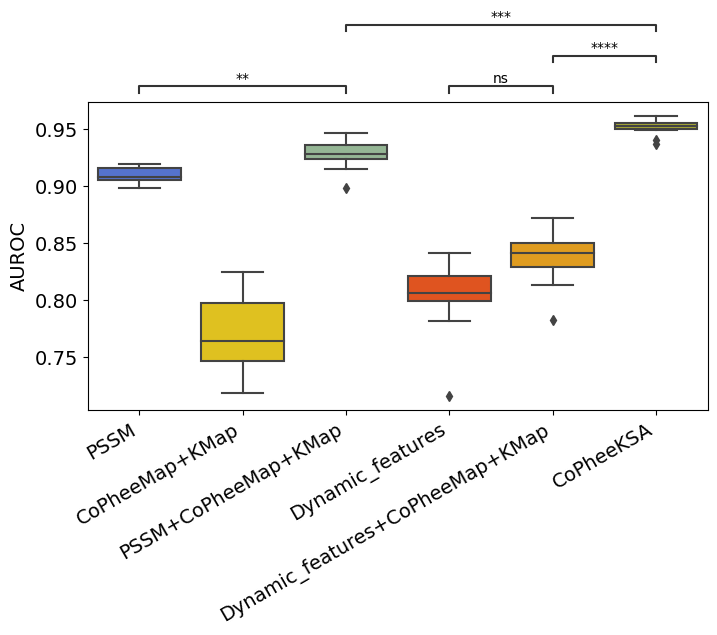

In [28]:
plt.figure(figsize=(8, 4))
x = "label"
y = "AUROC"
#hue = "label"
ax = sns.boxplot(data=tmp, x=x, y=y,palette=['royalblue','gold','darkseagreen','orangered','orange']+[sns.color_palette()[8]])
add_stat_annotation(ax, data=tmp, x=x, y=y,
                    box_pairs=[('PSSM', 'PSSM+CoPheeMap+KMap'),
                               ('Dynamic_features','Dynamic_features+CoPheeMap+KMap'),
                               ('PSSM+CoPheeMap+KMap','CoPheeKSA'),
                               ('Dynamic_features+CoPheeMap+KMap','CoPheeKSA')],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xticks(rotation=30,size=14,ha='right')
plt.yticks(size=14)
#plt.title('PSSM zscores',size=14)
plt.xlabel('')
plt.ylabel('AUROC',size=14)
#plt.legend(['PSSM','CoPheeMap+KMap','PSSM+CoPheeMap+KMap','Dynamic features','Dynamic features+CoPheeMap+KMap',
#            'CoPheeKSA'],loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=12)
plt.savefig('CoPheeKSA/comparision_auroc_KSA.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [332]:
#Train a final model CoPheeKSA using Dynamic features + PSSM + CoPheeMap + KMap
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
for i in random.sample(range(10),1):
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train[~data_train['PSSM'].isna()]
    
    data_neg=pd.read_csv('Supplementary_table/Table_S3_negative_KSA_w_features.tsv.zip', compression='zip', sep='\t')
    data_neg=data_neg.drop_duplicates()
    data_neg.index=range(len(data_neg))
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_eval_neg=data_neg.iloc[idx]
    idx_removed=data_eval_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_test_neg=data_neg.iloc[idx]
    idx_removed=data_test_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_eval_neg=data_eval_neg[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_eval_neg])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_eval_neg))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    #bst.save_model('CoPheeKSA/model/best_xgboost.model')
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)

[0]	train-auc:0.87802	eval-auc:0.88560
[1]	train-auc:0.88141	eval-auc:0.88400
[2]	train-auc:0.89189	eval-auc:0.90080
[3]	train-auc:0.89877	eval-auc:0.90272
[4]	train-auc:0.89865	eval-auc:0.90168
[5]	train-auc:0.90154	eval-auc:0.91376
[6]	train-auc:0.90182	eval-auc:0.91480
[7]	train-auc:0.90244	eval-auc:0.91744
[8]	train-auc:0.90297	eval-auc:0.91696
[9]	train-auc:0.90458	eval-auc:0.91744
[10]	train-auc:0.90615	eval-auc:0.91704
[11]	train-auc:0.90972	eval-auc:0.91648
[12]	train-auc:0.91130	eval-auc:0.91336
[13]	train-auc:0.91121	eval-auc:0.91288
[14]	train-auc:0.91177	eval-auc:0.91320
[15]	train-auc:0.91367	eval-auc:0.91912
[16]	train-auc:0.91639	eval-auc:0.93312
[17]	train-auc:0.91722	eval-auc:0.93272
[18]	train-auc:0.91852	eval-auc:0.92976
[19]	train-auc:0.92137	eval-auc:0.93216
[20]	train-auc:0.92185	eval-auc:0.93392
[21]	train-auc:0.92300	eval-auc:0.93368
[22]	train-auc:0.92416	eval-auc:0.93504
[23]	train-auc:0.92500	eval-auc:0.93376
[24]	train-auc:0.92603	eval-auc:0.93552
[25]	train

Pass `evals` as keyword args.


[26]	train-auc:0.92743	eval-auc:0.93600
[27]	train-auc:0.92800	eval-auc:0.93728
[28]	train-auc:0.92872	eval-auc:0.93664
[29]	train-auc:0.92972	eval-auc:0.93664
[30]	train-auc:0.93036	eval-auc:0.93776
[31]	train-auc:0.93169	eval-auc:0.93904
[32]	train-auc:0.93193	eval-auc:0.93936
[33]	train-auc:0.93251	eval-auc:0.94080
[34]	train-auc:0.93330	eval-auc:0.94064
[35]	train-auc:0.93383	eval-auc:0.93712
[36]	train-auc:0.93406	eval-auc:0.94144
[37]	train-auc:0.93449	eval-auc:0.94432
[38]	train-auc:0.93485	eval-auc:0.94432
[39]	train-auc:0.93548	eval-auc:0.94288
[40]	train-auc:0.93608	eval-auc:0.94304
[41]	train-auc:0.93644	eval-auc:0.94160
[42]	train-auc:0.93707	eval-auc:0.94352
[43]	train-auc:0.93745	eval-auc:0.94512
[44]	train-auc:0.93768	eval-auc:0.94560
[45]	train-auc:0.93800	eval-auc:0.94544
[46]	train-auc:0.93828	eval-auc:0.94576
[47]	train-auc:0.93871	eval-auc:0.94640
[48]	train-auc:0.93926	eval-auc:0.94736
[49]	train-auc:0.93986	eval-auc:0.94880
[50]	train-auc:0.94067	eval-auc:0.94928


In [334]:
#Store the test data
idx=random.sample(range(len(data_neg)),100*len(data_test))
data_neg2=data_neg.iloc[idx,:]
X_test=pd.concat([data_test,data_neg2])
X_test=X_test[col_idx]
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)
y_test=pd.DataFrame(y_test)

#X_test.to_csv('CoPheeKSA/model/X_test.csv')
#y_test.to_csv('CoPheeKSA/model/y_test.csv')

In [22]:
#X_test=pd.read_csv('CoPheeKSA/model/X_test.csv',index_col=0)
#y_test=pd.read_csv('CoPheeKSA/model/y_test.csv',index_col=0)

In [23]:
bst = xgb.Booster()
bst.load_model('CoPheeKSA/model/best_xgboost.model')

In [436]:
#Predict KSAs using CoPheeKSA
#Warning: Long running time and original data will be replaced by the new data
bst = xgb.Booster()
bst.load_model('CoPheeKSA/model/best_xgboost.model')
mypath='CoPheeKSA/prediction_data/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if isfile(''.join([mypath, f]))]

path2='CoPheeKSA/PSSM/ST/'
onlyfiles2 = [f for f in listdir(path2) if f!='.DS_Store']
onlyfiles2 = [f for f in onlyfiles2 if 'family' not in f]
ST_k=[f.split('_')[0] for f in onlyfiles2]
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
for f in onlyfiles:
    kinase=f.split('.')[0]
    if kinase in ST_k:
        print(kinase)
        data=pd.read_csv(''.join([mypath,f]),index_col=0)
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.index=data.sites
        score=[]
        data=data[col_idx]
        y_test=np.repeat(0,len(data))
        dtest = xgb.DMatrix(data, label=y_test)
        prediction = bst.predict(dtest)
        data['prediction']=np.array(prediction)
        data.to_csv(''.join(['CoPheeKSA/prediction/',f]))

RAF1
IKBKB
CASK
PAK3
MKNK1
PAK2
CAMK2A
LATS2
CDC7
PINK1
MAPK7
PAK1
CAMK2B
MAPK6
LATS1
DAPK1
DYRK2
PAK4
CAMK2G
MAPK3
PRKACA
PRKD2
IKBKE
DAPK2
MAPK1
MARK3
CAMK2D
MARK2
PRKD1
TBK1
DAPK3
PRKCD
RPS6KA1
ULK1
GRK5
MELK
STK3
GRK4
BUB1
PRKCE
PRKCG
NEK7
GRK6
SMG1
NEK6
TAF1
RPS6KA3
PRKCB
PKN1
AKT2
SIK2
NEK2
PDK2
TRPM7
STK4
CDK12
CLK2
AKT3
MAP3K8
WNK1
ARAF
WNK3
PRKCA
CDK9
AKT1
ILK
TTK
PDK1
NEK1
EIF2AK2
ATR
RPS6KA5
CDK8
CDK5
MTOR
PLK4
ROCK1
SRPK1
SGK3
DYRK1A
TGFBR2
CDK4
MAP3K7
PIM1
MAP3K5
CDK6
OXSR1
SGK1
ROCK2
DYRK1B
CDK7
CDK3
PLK2
CAMK4
PLK3
CHEK1
CDK2
MAP3K1
MAP3K3
NUAK1
PLK1
HIPK2
ATM
NEK9
CDK1
CHEK2
MAP3K2
LRRK2
CHUK
BRAF
MAP2K4
MAP2K6
MAPKAPK3
MAPKAPK2
MAPK15
MAP2K7
IRAK4
MAP4K1
PDPK1
STK38
GSK3B
MAP2K3
MAPK10
CSNK2A1
STK11
AURKA
MAPK8
GSK3A
CSNK2A2
MAP2K1
MAPK9


In [438]:
#Threshold when LLR>0.55
thred_55=0.767626

#Collect positive predicted KSAs
mypath='CoPheeKSA/prediction/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
ks1=[i.split('_')[0] for i in onlyfiles]
print(len(ks1))
combined_pos=pd.DataFrame()
for f in onlyfiles:
    print(f)
    kinase=f.split('.')[0]
    data=pd.read_csv(''.join([mypath,'/',f]),index_col=0)
    data=data.sort_values('prediction',ascending=False)
    data_pos=data[data.prediction>thred_55]
    #data_pos=data_pos.iloc[:1000]
    data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
    print(len(data_pos))
    combined_pos=pd.concat([combined_pos,data_pos])

131
RAF1.csv
19
IKBKB.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
CASK.csv
69
PAK3.csv
20
MKNK1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


441
PAK2.csv
0
CAMK2A.csv
0
LATS2.csv
43
CDC7.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10
PINK1.csv
1
MAPK7.csv
423
PAK1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
CAMK2B.csv
21
MAPK6.csv
29
LATS1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8
DAPK1.csv
0
DYRK2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


191
PAK4.csv
11
CAMK2G.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


28
MAPK3.csv
744
PRKACA.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


120
PRKD2.csv
28
IKBKE.csv
0
DAPK2.csv
141
MAPK1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


973
MARK3.csv
17
CAMK2D.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2
MARK2.csv
45
PRKD1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


44
TBK1.csv
0
DAPK3.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12
PRKCD.csv
1
RPS6KA1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


95
ULK1.csv
0
GRK5.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
MELK.csv
0
STK3.csv
0
GRK4.csv
0
BUB1.csv
0
PRKCE.csv
0
PRKCG.csv
0
NEK7.csv
140
GRK6.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8
SMG1.csv
318
NEK6.csv
2
TAF1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


461
RPS6KA3.csv
12
PRKCB.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
PKN1.csv
25
AKT2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


85
SIK2.csv
112
NEK2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
PDK2.csv
104
TRPM7.csv
0
STK4.csv
0
CDK12.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2131
CLK2.csv
15
AKT3.csv
287
MAP3K8.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3
WNK1.csv
5
ARAF.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9
WNK3.csv
4
PRKCA.csv
10
CDK9.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


384
AKT1.csv
202
ILK.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


22
TTK.csv
0
PDK1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


26
NEK1.csv
0
EIF2AK2.csv
0
ATR.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


26
RPS6KA5.csv
49
CDK8.csv
2009
CDK5.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


482
MTOR.csv
9
PLK4.csv
0
ROCK1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2
SRPK1.csv
813
SGK3.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


515
DYRK1A.csv
49
TGFBR2.csv
0
CDK4.csv
1024
MAP3K7.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
PIM1.csv
14
MAP3K5.csv
0
CDK6.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

560
OXSR1.csv
1
SGK1.csv
94
ROCK2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8
DYRK1B.csv
17
CDK7.csv
36
CDK3.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


334
PLK2.csv
44
CAMK4.csv
17
PLK3.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


32
CHEK1.csv
4
CDK2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2101
MAP3K1.csv
1379
MAP3K3.csv
53
NUAK1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


54
PLK1.csv
6
HIPK2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


247
ATM.csv
19
NEK9.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


48
CDK1.csv
2844
CHEK2.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3
MAP3K2.csv
37
LRRK2.csv
0
CHUK.csv
0
BRAF.csv
1
MAP2K4.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4
MAP2K6.csv
5
MAPKAPK3.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


270
MAPKAPK2.csv
75
MAPK15.csv
20
MAP2K7.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


18
IRAK4.csv
0
MAP4K1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


253
PDPK1.csv
18
STK38.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


41
GSK3B.csv
135
MAP2K3.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9
MAPK10.csv
237
CSNK2A1.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


574
STK11.csv
69
AURKA.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
MAPK8.csv
429
GSK3A.csv



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


363
CSNK2A2.csv
320
MAP2K1.csv
7
MAPK9.csv
333



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [440]:
#combined_pos.to_csv('CoPheeKSA/results/K_S_CoPhee_llr55_w_features.csv')